In [186]:
import requests
import os
from datetime import datetime
from pathlib import Path
import pyarrow
import geopandas as gpd 
import pandas as pd 
import matplotlib.pyplot as plt

In [187]:
# Download latest fire boundaries from CalFire on ARCGIS API
url = "https://hub.arcgis.com/api/v3/datasets/025fb2ea05f14890b2b11573341b5b18_0/downloads/data?format=geojson&spatialRefId=4326&where=1%3D1"
output_dir = "/Volumes/squirrel-utopia 1/los_angeles_2025_fire_disasters_exp/los_angeles_2025_fire_disasters_exp/data/calfire_boundaries"
data_dir = "/Volumes/squirrel-utopia 1/los_angeles_2025_fire_disasters_exp/los_angeles_2025_fire_disasters_exp/data"

In [188]:
# generate a filename with the current date
filename = f"data_{datetime.now().strftime('%Y_%m_%d')}.geojson"
output_path = os.path.join(output_dir, filename)

# check 
print(filename)
print(output_path)

data_2025_01_14.geojson
/Volumes/squirrel-utopia 1/los_angeles_2025_fire_disasters_exp/los_angeles_2025_fire_disasters_exp/data/calfire_boundaries/data_2025_01_14.geojson


In [189]:
# Download the file
response = requests.get(url)
# Check if the request was successful
response.raise_for_status()  

In [190]:
# Save
with open(output_path, "wb") as file:
    file.write(response.content)

In [191]:
# Read in data - contains wf data going back to 2024 or 2023 - want only 
# dates since January 7th, 2025
fires = gpd.read_file(output_path)
fires = fires[fires['poly_DateCurrent'] > '2025-01-06']

<Axes: >

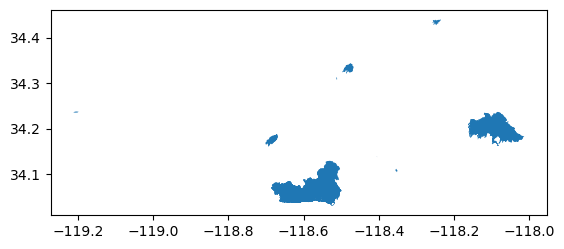

In [192]:
# Plot fires
fires.plot()

In [193]:
# Let's list them: 
# - Palisades Fire
# - Eaton Fire
# - Hurst Fire 
# - Auto Fire
# - Sunset Fire
# - Lidia Fire
# - Archer Fire 
# - Kenneth Fire
# as of Jan 14th, 2024

In [194]:
# need to get the largest burned area for each fire
# want to union all geometries together 
print(fires)

      OBJECTID                              GlobalID            type  \
1175      1262  7ee0ab36-f6af-4ca9-96ed-170ebc0b0ba0  Heat Perimeter   
1176      1263  f4b2a2f8-b549-425a-8420-e11c78a5a9da  Heat Perimeter   
1177      1264  0bc1ddb3-63bf-4fd8-a01b-d522f57e4083  Heat Perimeter   
1178      1265  80a365ca-2de5-434e-8bd8-195405caefec  Heat Perimeter   
1179      1266  34c2af2a-54f0-4830-a99e-bd47edb2b503  Heat Perimeter   
1180      1267  98243b68-f4d5-4467-b19f-cf88106e18e7  Heat Perimeter   
1181      1268  0d7d92b4-e5b5-464e-a02b-e70dbd80d06d  Heat Perimeter   
1182      1269  92579339-7dd4-4dd8-95c5-910ef0bb2c07  Heat Perimeter   
1183      1270  38e2219f-62eb-45f1-9016-8c3046633b97  Heat Perimeter   
1184      1271  77755bff-6eb1-4e42-9809-1ad373ce6bdc  Heat Perimeter   
1185      1272  feb591e5-3665-47a4-b745-5787b15b5c84  Heat Perimeter   
1186      1273  f7dffefc-992a-49d0-84e9-15f92126fc04  Heat Perimeter   
1187      1274  6e9f9314-31fa-4114-b005-62effc0f7e29  Heat Perim

In [195]:
# Perform unary union to merge intersecting polygons
merged_fires = fires.geometry.unary_union

# If you want to convert the result back to a GeoDataFrame
merged_fires = gpd.GeoDataFrame(geometry=[merged_fires], crs=fires.crs)
print(merged_fires)

/var/folders/8y/9yw138b95kjd5wjs3my5vy900000gn/T/ipykernel_32028/561589912.py:2: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  merged_fires = fires.geometry.unary_union


                                            geometry
0  MULTIPOLYGON (((-118.54 34.037, -118.54 34.037...


<Axes: >

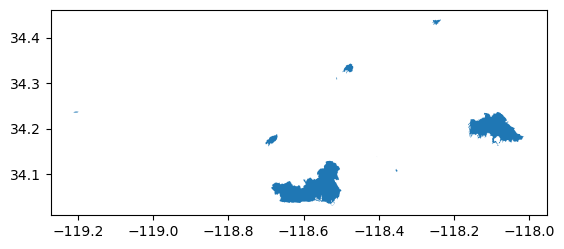

In [196]:
# plot merged fires
merged_fires.plot()

In [197]:
# Read in ZCTA data 
zcta_path = os.path.join(data_dir, 'zctas_2020.parquet')
zctas = gpd.read_parquet(zcta_path)
# Add column which is area of each zcta
zctas['zcta_area'] = zctas.area

/var/folders/8y/9yw138b95kjd5wjs3my5vy900000gn/T/ipykernel_32028/436734147.py:5: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  zctas['zcta_area'] = zctas.area


/var/folders/8y/9yw138b95kjd5wjs3my5vy900000gn/T/ipykernel_32028/1996211507.py:2: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: GEOGCRS["GCS_North_American_1983",
    DATUM["D_No ...
Right CRS: EPSG:4326

  zctas_fires = gpd.overlay(zctas, merged_fires, how='intersection')


<Axes: >

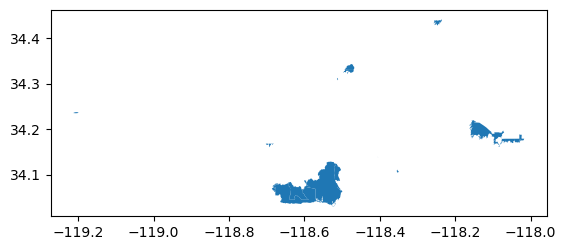

In [198]:
# Intersect zctas with fires 
zctas_fires = gpd.overlay(zctas, merged_fires, how='intersection')
# Plot
zctas_fires.plot()

In [199]:
print(zctas_fires)

   ZCTA5CE20 GEOID20 CLASSFP20 MTFCC20 FUNCSTAT20      ALAND20    AWATER20  \
0      91001   91001        B5   G6350          S   21393347.0     91219.0   
1      91302   91302        B5   G6350          S   71094708.0    116015.0   
2      91604   91604        B5   G6350          S   12277522.0    187999.0   
3      90049   90049        B5   G6350          S   38778176.0      1359.0   
4      90290   90290        B5   G6350          S   48498335.0     24096.0   
5      91344   91344        B5   G6350          S   37456572.0    870003.0   
6      90272   90272        B5   G6350          S   61670603.0   1423894.0   
7      91321   91321        B5   G6350          S   69047146.0     32803.0   
8      90265   90265        B5   G6350          S  287514073.0  18899708.0   
9      91006   91006        B5   G6350          S   16652745.0    488299.0   
10     91016   91016        B5   G6350          S   21957687.0    125531.0   
11     91024   91024        B5   G6350          S    9051029.0  

In [200]:
# Add column which is area of intersection of zcta x fire
zctas_fires['zcta_fire_intersection_area'] = zctas_fires.area
print(zctas_fires)

   ZCTA5CE20 GEOID20 CLASSFP20 MTFCC20 FUNCSTAT20      ALAND20    AWATER20  \
0      91001   91001        B5   G6350          S   21393347.0     91219.0   
1      91302   91302        B5   G6350          S   71094708.0    116015.0   
2      91604   91604        B5   G6350          S   12277522.0    187999.0   
3      90049   90049        B5   G6350          S   38778176.0      1359.0   
4      90290   90290        B5   G6350          S   48498335.0     24096.0   
5      91344   91344        B5   G6350          S   37456572.0    870003.0   
6      90272   90272        B5   G6350          S   61670603.0   1423894.0   
7      91321   91321        B5   G6350          S   69047146.0     32803.0   
8      90265   90265        B5   G6350          S  287514073.0  18899708.0   
9      91006   91006        B5   G6350          S   16652745.0    488299.0   
10     91016   91016        B5   G6350          S   21957687.0    125531.0   
11     91024   91024        B5   G6350          S    9051029.0  

/var/folders/8y/9yw138b95kjd5wjs3my5vy900000gn/T/ipykernel_32028/3066510252.py:2: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  zctas_fires['zcta_fire_intersection_area'] = zctas_fires.area


In [201]:
# From zctas_fires, select zcta name, zcta area, and zcta fire intersection 
# area, and fire name, although fire name is missing in 90% of cases
zctas_fires = zctas_fires[['ZCTA5CE20', 'zcta_area', 'zcta_fire_intersection_area', 'geometry']]
# rename ZCTA5CE20 to zcta
zctas_fires.rename(columns={'ZCTA5CE20': 'zcta'}, inplace=True)

/var/folders/8y/9yw138b95kjd5wjs3my5vy900000gn/T/ipykernel_32028/1519367099.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  zctas_fires.rename(columns={'ZCTA5CE20': 'zcta'}, inplace=True)


In [202]:
# Calculate area affected by each fire within each zcta
zctas_fires = zctas_fires.drop(columns='geometry')
# Group by zcta and sum the variable zcta_fire_intersection_area
zctas_fires_sum = zctas_fires.groupby('zcta').agg({
    'zcta_fire_intersection_area': 'sum',
    'zcta_area': 'first'  # or 'mean', 'max', etc., depending on your needs
}).reset_index()
# Add col which is zcta_fire_intersection_area / zcta_area
zctas_fires_sum['fire_area_ratio'] = zctas_fires_sum['zcta_fire_intersection_area'] / zctas_fires_sum['zcta_area'] * 100


In [203]:
print(zctas_fires_sum)

     zcta  zcta_fire_intersection_area  zcta_area  fire_area_ratio
0   90046                 1.752825e-05   0.001434         1.222299
1   90049                 4.564542e-04   0.003788        12.049650
2   90265                 2.751597e-03   0.029926         9.194816
3   90272                 4.706798e-03   0.006163        76.375635
4   90290                 1.100134e-03   0.004740        23.207770
5   90402                 5.372413e-06   0.000548         0.979874
6   91001                 1.336501e-03   0.002101        63.603295
7   91006                 4.413339e-05   0.001675         2.634326
8   91016                 3.899938e-08   0.002159         0.001807
9   91024                 3.095106e-04   0.000886        34.933469
10  91103                 1.670514e-06   0.001168         0.143070
11  91104                 1.529941e-06   0.000956         0.160031
12  91107                 4.789199e-04   0.002158        22.191633
13  91302                 1.171812e-04   0.006959         1.68

In [204]:
# OK now to merge w Kaiser data
# read in kaiser zips
kaiser_zips_path = os.path.join(data_dir, 'kpsc_zcta_counts.csv')
kaiser_zips = pd.read_csv(kaiser_zips_path)

In [205]:
# view kaiser zips
kaiser_zips.head()

,zcta,kpsc_pop_age_60p,classification
0,90001,1684,General
1,90002,1627,General
2,90003,2133,General
3,90004,2372,General
4,90005,880,General


In [206]:
# Change zcta to character type in kaiser
kaiser_zips['zcta'] = kaiser_zips['zcta'].astype(str)
# Change in zcta_fires_sum to character type
zctas_fires_sum['zcta'] = zctas_fires_sum['zcta'].astype(str)

# Left join kaiser zips to zctas_fires_sum
zctas_fires_sum = zctas_fires_sum.merge(kaiser_zips, how='left')

In [207]:
# Change the fire area ratio to max out at 100 - zctas where it's higher 
# have that bc of the way the ZCTA file is set up
zctas_fires_sum['fire_area_ratio'] = zctas_fires_sum['fire_area_ratio'].clip(upper=100)

# Make a new col fire_area_ratio times kaiser count
zctas_fires_sum['ppl_affected'] = zctas_fires_sum['fire_area_ratio'] * zctas_fires_sum['kpsc_pop_age_60p'] / 100

In [208]:
# Remove column 'classification'
zctas_fires_sum = zctas_fires_sum.drop(columns='classification')

# Sort descending by ppl affected
zctas_fires_sum = zctas_fires_sum.sort_values(by='ppl_affected', ascending=False)
# Round ppl affected up to the nearest integer
zctas_fires_sum['ppl_affected'] = zctas_fires_sum['ppl_affected'].apply(lambda x: round(x))

In [209]:
# Write as csv
zctas_fires_sum_path = os.path.join(data_dir, 'num_kaiser_pop_age_60_affected_la_wf.csv')
zctas_fires_sum.to_csv(zctas_fires_sum_path, index=False)
